# Study of [EPIC246067459](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246067459)

/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:141: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)
/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:141: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


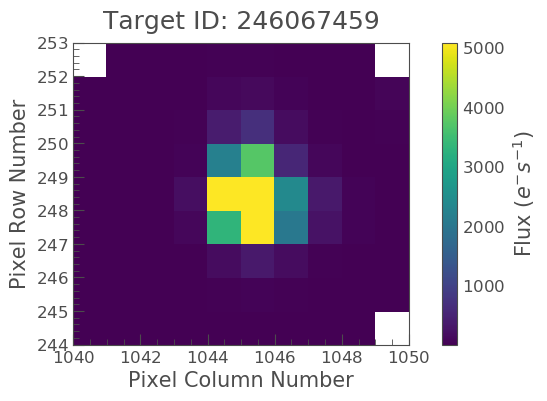

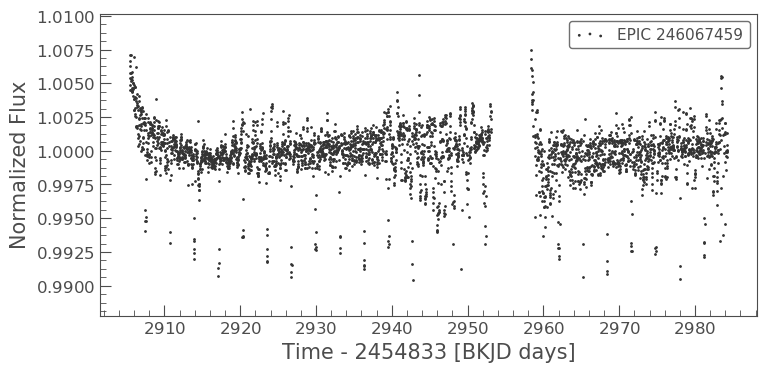

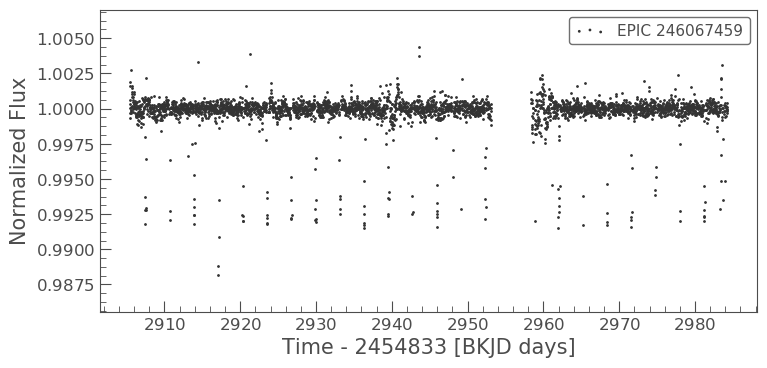

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
from astropy.stats import BoxLeastSquares
import matplotlib.pyplot as plt
import math

target = '246067459'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.remove_nans().remove_outliers()
lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=40)
corr_lc_f, trend = corr_lc.flatten(window_length=401, return_trend=True)
corr_lc_f.scatter()

In [16]:
corr_lc.time_format = 'bjd'

# Creating a file to store the data
f = open("246067459.txt", "w+")

for i in range(len(corr_lc.flux)):
    L = [str(corr_lc.time[i]+2454833), " ", str(corr_lc.flux[i]), " ", str(corr_lc.flux_err[i]), "\n"]
    f.writelines(L)
    
corr_lc.time_format = 'bkjd'

(<Time object: scale='tdb' format='jd' value=2457739.8476308775>,
 <Quantity 3.20754096 d>)

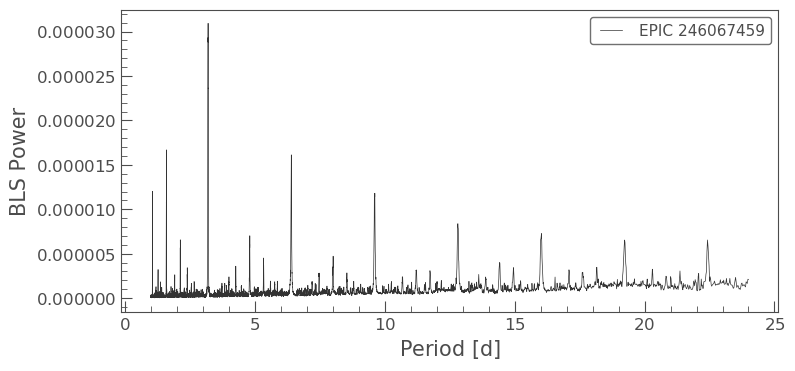

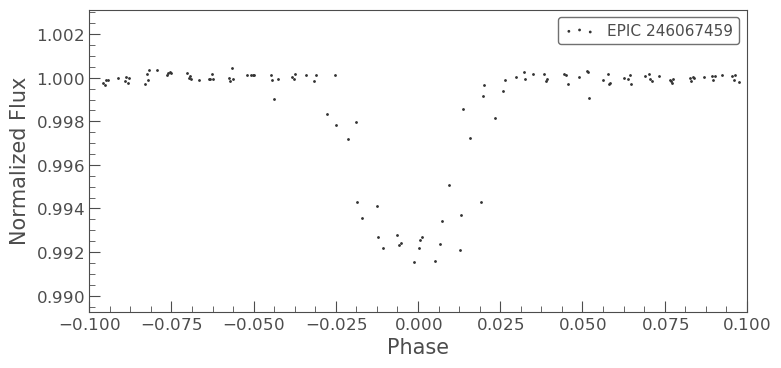

In [20]:
pg = corr_lc.to_periodogram("bls", minimum_period=1, maximum_period=24, frequency_factor=5, duration=0.05)
pg.plot();
lc_transit = corr_lc.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(5)
lc_transit.scatter()
plt.xlim([-0.1, 0.1]);
pg.transit_time_at_max_power+corr_lc.astropy_time[0], pg.period_at_max_power,

In [21]:
R_star = 0.876 # in sun's radius
R_star = R_star * 695510000 # in meter

Td_values = lc_transit.time[lc_transit.flux < 0.998]
Td = Td_values[-1] - Td_values[0]

min_tr = lc_transit.flux[lc_transit.flux < 0.998].mean()
R_planet = math.sqrt(1-min_tr)*R_star
R_planet = R_planet / 695510000 # in jupiter's radius

Td , R_planet

(0.043982883981516355, 0.0693620527017557)

In [22]:
G = 6.67408 * 10**(-11)
P = pg.period_at_max_power.value*86400
M = 0.971*1.98847*10**30
a_m = (G*M*P**2/(2*math.pi)**2) ** (1./3)
i = math.acos(math.sqrt((R_star/a_m)**2 - (Td*math.pi/P)**2)) # in radians
b = a_m * math.cos(i)

a_au = a_m / (1.496*10**11) #R_star # astronomical unit
a_star = a_m / R_star # astronomical unit
b = b / R_star
i = math.degrees(i)

a_au, a_star, i, b

(0.04214852265126049, 10.349192509088416, 84.4550926301356, 0.9999999999866881)

| symbol | parameter                         | units   | value       |
|--------|-----------------------------------|---------|-------------|
| P      | Period                            | days    | 3.208034    |
| a      | Semi-Major Axis                   | AU      | 0.045144    |
| Rp     | Planet Radius                     | Rj      | 1.297776    |
| Teq    | Equilibrium Temperature           | K       | 1612.129586 |
| u1     | Linear Limb-Darkening Coeff       | none    | 0.450378    |
| u2     | Quadratic Limb-Darkening Coeff    | none    | 0.238925    |
| i      | Inclination                       | degrees | 84.498574   |
| b      | Impact Parameter                  | none    | 0.584722    |
| delta  | Transit Depth                     | none    | 0.007021    |
| TFWHM  | FWHM Duration                     | days    | 0.136492    |
| tau    | Ingress/Egress Duration           | days    | 0.017580    |
| T14    | Total Duration                    | days    | 0.154072    |   
  
Now, we can replot our curve with our data:

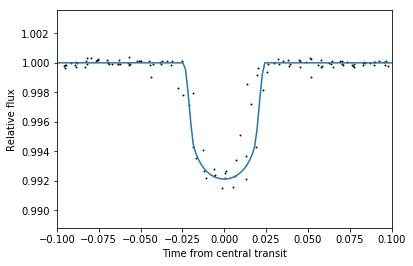

0.023931404912823296

In [27]:
import batman

params = batman.TransitParams()
params.t0 = 0                     #time of inferior conjunction
params.per = abs(lc_transit[-1].phase - lc_transit[0].phase)                      #orbital period
params.rp = 0.083790                     #planet radius (in units of stellar radii)
params.a = 6.099077                     #semi-major axis (in units of stellar radii)
params.inc = 84.603981                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.450655, 0.238882]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

t = np.linspace(lc_transit[0].phase, lc_transit[-1].phase, len(lc_transit.flux))    #where the transit is

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlim([-0.1, 0.1]);
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

diff = 0

for i in range(0,len(flux)):
            diff += 100*abs(lc_transit.flux[i]-flux[i])
        
diff/len(flux)